In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 1. Load data

In [2]:
def load_all_from_path(path: str):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in tqdm(sorted(glob(path + "/*.png")))]).astype(np.float32) / 255.0


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f"Image {i}")
        axs[1, i].set_title(f"Mask {i}")
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


In [3]:
train_path = "../data/training"

train_images = load_all_from_path(os.path.join(train_path, "images"))
train_masks = load_all_from_path(os.path.join(train_path, "groundtruth"))

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

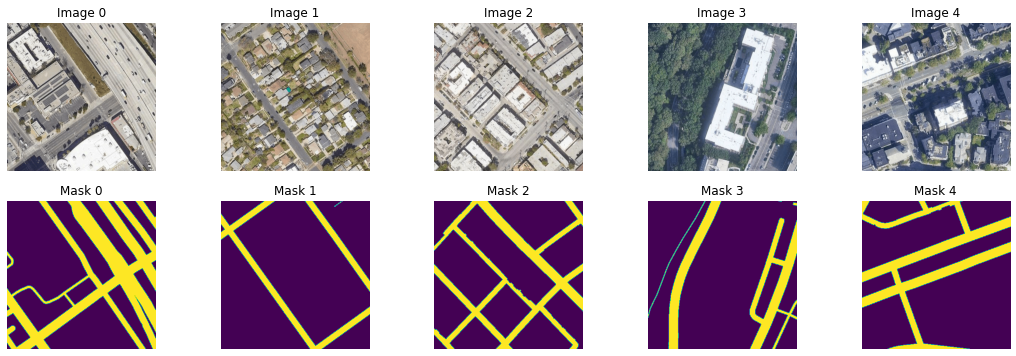

In [4]:
show_first_n(train_images, train_masks, n=5)